# Réseau neuronal convolutif (CNN)

Cet exercice illustre la formation d'un réseau de neurones convolutifs (CNN) pour classer les images CIFAR. On utilise l'API séquentielle Keras. La création et la formation de votre modèle ne prendront que quelques lignes de code.

In [1]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

2024-06-28 16:54:20.107461: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Télécharger et préparer le jeu de données CIFAR10

L'ensemble de données CIFAR10 contient 60 000 images couleur dans 10 classes, avec 6 000 images dans chaque classe. L'ensemble de données est divisé en 50 000 images d'entraînement et 10 000 images de test. 

In [2]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

In [3]:
type(train_images)
train_images.shape
test_images.shape

(10000, 32, 32, 3)

### Vérifier les données

Pour vérifier que l'ensemble de données semble correct, traçons les 25 premières images de l'ensemble d'apprentissage et affichons le nom de la classe sous chaque image :

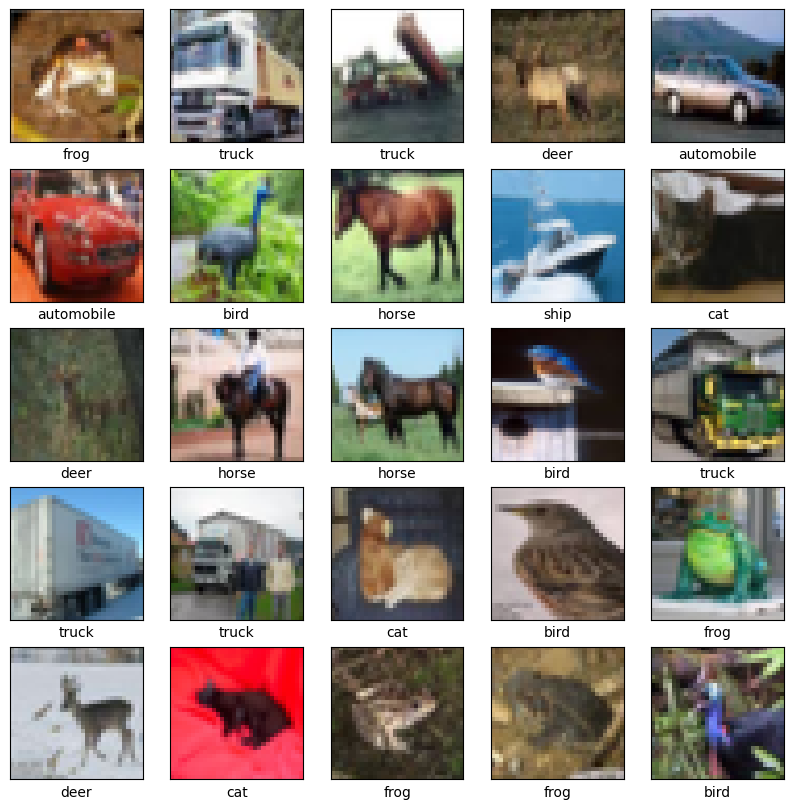

In [4]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

### Créer la base convolutive
Les 6 lignes de code ci-dessous définissent la base convolutive en utilisant un modèle commun : une pile de couches Conv2D et MaxPooling2D .

En entrée, un CNN prend des tenseurs de forme (image_height, image_width, color_channels), en ignorant la taille du lot. Si vous débutez avec ces dimensions, color_channels fait référence à (R,G,B). Dans cet exemple, vous allez configurer votre CNN pour traiter les entrées de forme (32, 32, 3), qui est le format des images CIFAR. Vous pouvez le faire en passant l'argument input_shape à votre première couche.

[Documentation de la classe Sequential](https://keras.io/api/models/sequential/)

In [5]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

**Instructions**: Affichez l'architecture de votre modèle jusqu'à présent.
Utilisez pour cela la méthode `.summary()``


In [6]:
# Code ici
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 64)          36928     
                                                                 
Total params: 56,320
Trainable params: 56,320
Non-traina

### Ajouter des couches denses sur le dessus
Pour compléter le modèle, vous allez alimenter le dernier tenseur de sortie de la base convolutive (de forme (4, 4, 64)) dans une couche dense pour effectuer la classification. 

Les couches denses prennent des vecteurs en entrée (qui sont 1D), tandis que la sortie actuelle est un tenseur 3D. 

* Tout d'abord, vous allez aplatir (ou dérouler) la sortie 3D en 1D, puis 
* ajouter un calques Dense par-dessus. 
* CIFAR a 10 classes de sortie, vous utilisez donc une couche Dense finale avec 10 sorties.

In [7]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 64)          36928     
                                                                 
 flatten (Flatten)           (None, 1024)              0

Le résumé du réseau montre que (4, 4, 64) les sorties ont été aplaties en vecteurs de forme (1024) avant de passer par deux couches Dense.

### Compiler et entraîner le modèle

**Notes**

> [Documentation pour les fonctions de cout](https://keras.io/api/losses/probabilistic_losses/#categoricalcrossentropy-class)

> Par défaut, la taille du Batch (i.e., nombre d'échantillons par mise-à-jour du gradient) est de 32 ([Model.fit(...)](https://keras.io/api/models/model_training_apis/)). 

Avec 50000 images d'entrainement (pour chaque Epoch), on met donc à jour les gradients 1563 fois.

In [9]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=15, 
                    validation_data=(test_images, test_labels))

Epoch 1/15
1563/1563 [==============================] - 49s 30ms/step - loss: 1.5287 - accuracy: 0.4442 - val_loss: 1.2116 - val_accuracy: 0.5696
Epoch 2/15
1563/1563 [==============================] - 47s 30ms/step - loss: 1.1508 - accuracy: 0.5929 - val_loss: 1.0987 - val_accuracy: 0.6151
Epoch 3/15
1563/1563 [==============================] - 37s 24ms/step - loss: 1.0031 - accuracy: 0.6481 - val_loss: 0.9890 - val_accuracy: 0.6569
Epoch 4/15
1563/1563 [==============================] - 47s 30ms/step - loss: 0.9033 - accuracy: 0.6848 - val_loss: 0.9407 - val_accuracy: 0.6720
Epoch 5/15
1563/1563 [==============================] - 48s 31ms/step - loss: 0.8289 - accuracy: 0.7101 - val_loss: 0.9084 - val_accuracy: 0.6824
Epoch 6/15
1563/1563 [==============================] - 47s 30ms/step - loss: 0.7695 - accuracy: 0.7288 - val_loss: 0.9248 - val_accuracy: 0.6812
Epoch 7/15
1563/1563 [==============================] - 46s 29ms/step - loss: 0.7168 - accuracy: 0.7490 - val_loss: 0.8767 -

### Évaluer le modèle

Visualisez l'évolution de l'Accuracy en fonction des Epoch

313/313 - 2s - loss: 1.0135 - accuracy: 0.7050 - 2s/epoch - 6ms/step


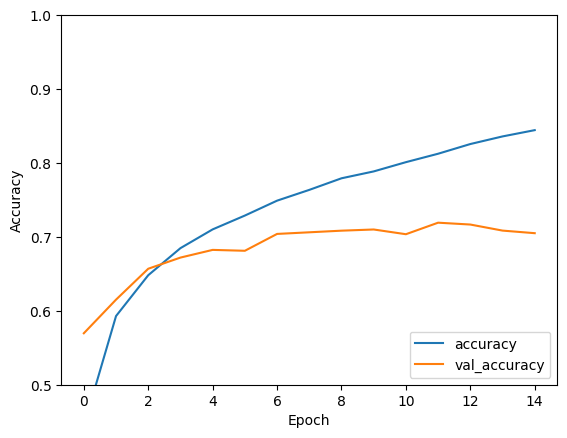

In [10]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

**Instructions**

Visualisez l'évolution de la foction de perte en fonction des Epoch

313/313 - 2s - loss: 1.0135 - accuracy: 0.7050 - 2s/epoch - 5ms/step


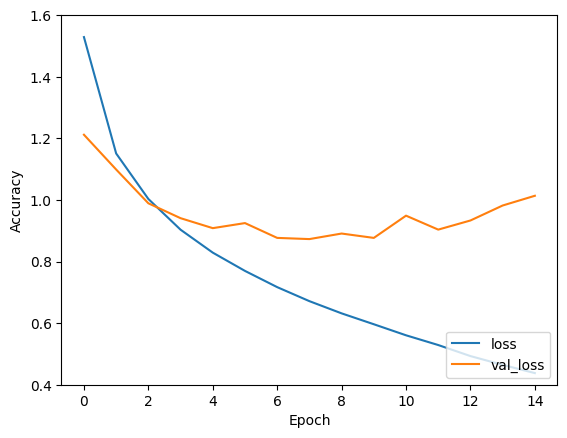

In [11]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.4, 1.6])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

## Références
[Convolutional Neural Network (CNN)](https://www.tensorflow.org/tutorials/images/cnn)

[Computer Vision - TenserFlow Tutorials](https://www.tensorflow.org/tutorials/images)